In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import _pickle as pickle

In [2]:
seed = 142
pd.options.display.max_columns = 50
np.random.seed(seed)

## Import data and check some stats

### Order data

In [3]:
order_data = pd.read_csv('machine_learning_challenge_order_data.csv')

In [4]:
order_data.shape

(786600, 13)

In [5]:
order_data.head(3)

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324


In [6]:
# Check number of clients
len(pd.unique(order_data['customer_id']))

245455

In [7]:
# Check data types
order_data.dtypes

customer_id             object
order_date              object
order_hour               int64
customer_order_rank    float64
is_failed                int64
voucher_amount         float64
delivery_fee           float64
amount_paid            float64
restaurant_id            int64
city_id                  int64
payment_id               int64
platform_id              int64
transmission_id          int64
dtype: object

In [8]:
# Check NA values
order_data.isna().sum(axis=0)

customer_id                0
order_date                 0
order_hour                 0
customer_order_rank    24767
is_failed                  0
voucher_amount             0
delivery_fee               0
amount_paid                0
restaurant_id              0
city_id                    0
payment_id                 0
platform_id                0
transmission_id            0
dtype: int64

In [9]:
# Check mean values in real columns
order_data.loc[:, 'customer_order_rank':'amount_paid'].mean(axis=0)

customer_order_rank     9.436810
is_failed               0.031486
voucher_amount          0.091489
delivery_fee            0.181180
amount_paid            10.183271
dtype: float64

In [10]:
# Check number of categorical values for 'id' columns
order_data['restaurant_id'].value_counts().shape[0],\
order_data['city_id'].value_counts().shape[0],\
order_data['payment_id'].value_counts().shape[0],\
order_data['platform_id'].value_counts().shape[0],\
order_data['transmission_id'].value_counts().shape[0]

(13569, 3749, 5, 14, 10)

### Labeled data

In [11]:
labeled_data = pd.read_csv('machine_learning_challenge_labeled_data.csv')

In [12]:
labeled_data.shape

(245455, 2)

In [13]:
labeled_data.dtypes

customer_id              object
is_returning_customer     int64
dtype: object

In [14]:
# Rate of positive/negative labels
labeled_data['is_returning_customer'].value_counts() / labeled_data.shape[0]

0    0.773861
1    0.226139
Name: is_returning_customer, dtype: float64

## Simple transformation of a client to one row data

In [15]:
# Create dummies for categorical columns with reasonable number of values
payment_id_dummies = pd.get_dummies(order_data['payment_id'], prefix='payment_id')
platform_id_dummies = pd.get_dummies(order_data['platform_id'], prefix='platform_id')
transmission_id_dummies = pd.get_dummies(order_data['transmission_id'], prefix='transmission_id')
dummies = [payment_id_dummies, platform_id_dummies, transmission_id_dummies]
# order_data.drop(['payment_id', 'platform_id', 'transmission_id'], axis=1, inplace=True)
order_data = pd.concat([order_data]+dummies, axis=1)

In [16]:
order_data.shape

(786600, 42)

In [17]:
order_data.columns

Index(['customer_id', 'order_date', 'order_hour', 'customer_order_rank',
       'is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid',
       'restaurant_id', 'city_id', 'payment_id', 'platform_id',
       'transmission_id', 'payment_id_1491', 'payment_id_1523',
       'payment_id_1619', 'payment_id_1779', 'payment_id_1811',
       'platform_id_525', 'platform_id_22167', 'platform_id_22263',
       'platform_id_22295', 'platform_id_29463', 'platform_id_29495',
       'platform_id_29751', 'platform_id_29815', 'platform_id_30135',
       'platform_id_30199', 'platform_id_30231', 'platform_id_30359',
       'platform_id_30391', 'platform_id_30423', 'transmission_id_212',
       'transmission_id_1988', 'transmission_id_2020', 'transmission_id_4196',
       'transmission_id_4228', 'transmission_id_4260', 'transmission_id_4324',
       'transmission_id_4356', 'transmission_id_4996',
       'transmission_id_21124'],
      dtype='object')

In [18]:
# Aggregate client to one row with simple functions

payment_cols = order_data.filter(regex='^payment_id_', axis=1).columns.tolist()
platform_cols = order_data.filter(regex='^platform_id_', axis=1).columns.tolist()
transmission_cols = order_data.filter(regex='^transmission_id_', axis=1).columns.tolist()

def custom_aggregate(df):
    df_agg = {}
    df_agg['customer_id'] = pd.unique(df['customer_id'])[0]
    df_agg['orders_num'] = len(df)
    df_agg['is_failed_num'] = np.sum(df['is_failed'])
    df_agg['voucher_amount_sum'] = np.sum(df['voucher_amount'])
    df_agg['delivery_fee_mean'] = np.mean(df['delivery_fee'])
    df_agg['delivery_fee_sum'] = np.sum(df['delivery_fee'])
    df_agg['delivery_fee_num'] = np.sum(df['delivery_fee'] > 0.)
    df_agg['restaurant_id_unq_num'] = len(pd.unique(df['restaurant_id']))
    df_agg['city_id_unq_num'] = len(pd.unique(df['city_id']))
    df_agg['payment_id_unq_num'] = len(pd.unique(df['payment_id']))
    df_agg['platform_id_unq_num'] = len(pd.unique(df['platform_id']))
    df_agg['transmission_id_unq_num'] = len(pd.unique(df['transmission_id']))
    df_agg['amount_paid_mean'] = np.mean(df['amount_paid'])
    df_agg['amount_paid_sum'] = np.sum(df['amount_paid'])
    df_agg['amount_paid_std'] = np.std(df['amount_paid'])
    df_agg['amount_paid_quantile75'] = df['amount_paid'].quantile(q=0.75)
    
    # aggregate payment dummy columns
    payment_cols_new = [col+'_num' for col in payment_cols]
    df_agg.update(dict(zip(payment_cols_new, df[payment_cols].apply(np.sum))))
    
    # aggregate platform dummy columns
    platform_cols_new = [col+'_num' for col in platform_cols]
    df_agg.update(dict(zip(platform_cols_new, df[platform_cols].apply(np.sum))))
    
    # aggregate transmission dummy columns
    transmission_cols_new = [col+'_num' for col in transmission_cols]
    df_agg.update(dict(zip(transmission_cols_new, df[transmission_cols].apply(np.sum))))
    
    return pd.Series(OrderedDict(df_agg))

In [19]:
orders_per_client = order_data.groupby('customer_id', as_index=False).apply(custom_aggregate)

In [20]:
orders_per_client.shape

(245455, 45)

In [21]:
orders_per_client.columns

Index(['customer_id', 'orders_num', 'is_failed_num', 'voucher_amount_sum',
       'delivery_fee_mean', 'delivery_fee_sum', 'delivery_fee_num',
       'restaurant_id_unq_num', 'city_id_unq_num', 'payment_id_unq_num',
       'platform_id_unq_num', 'transmission_id_unq_num', 'amount_paid_mean',
       'amount_paid_sum', 'amount_paid_std', 'amount_paid_quantile75',
       'payment_id_1491_num', 'payment_id_1523_num', 'payment_id_1619_num',
       'payment_id_1779_num', 'payment_id_1811_num', 'platform_id_525_num',
       'platform_id_22167_num', 'platform_id_22263_num',
       'platform_id_22295_num', 'platform_id_29463_num',
       'platform_id_29495_num', 'platform_id_29751_num',
       'platform_id_29815_num', 'platform_id_30135_num',
       'platform_id_30199_num', 'platform_id_30231_num',
       'platform_id_30359_num', 'platform_id_30391_num',
       'platform_id_30423_num', 'transmission_id_212_num',
       'transmission_id_1988_num', 'transmission_id_2020_num',
       'transmission

In [22]:
orders_per_client.dtypes

customer_id                   object
orders_num                     int64
is_failed_num                  int64
voucher_amount_sum           float64
delivery_fee_mean            float64
delivery_fee_sum             float64
delivery_fee_num               int64
restaurant_id_unq_num          int64
city_id_unq_num                int64
payment_id_unq_num             int64
platform_id_unq_num            int64
transmission_id_unq_num        int64
amount_paid_mean             float64
amount_paid_sum              float64
amount_paid_std              float64
amount_paid_quantile75       float64
payment_id_1491_num            int64
payment_id_1523_num            int64
payment_id_1619_num            int64
payment_id_1779_num            int64
payment_id_1811_num            int64
platform_id_525_num            int64
platform_id_22167_num          int64
platform_id_22263_num          int64
platform_id_22295_num          int64
platform_id_29463_num          int64
platform_id_29495_num          int64
p

In [23]:
# Save dataframe
orders_per_client.to_feather('orders_per_client.feather')
# orders_per_client = pd.read_feather('orders_per_client.feather')

### Check some stats

In [24]:
len(pd.unique(orders_per_client['city_id_unq_num'])),\
len(pd.unique(orders_per_client['restaurant_id_unq_num'])),\
np.mean(pd.unique(orders_per_client['city_id_unq_num'])),\
np.mean(pd.unique(orders_per_client['restaurant_id_unq_num']))

(16, 42, 10.5625, 22.357142857142858)

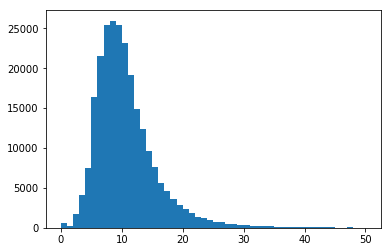

In [25]:
# Histogram for column 'amount_paid_mean'
plt.hist(orders_per_client[orders_per_client['amount_paid_mean'] < 50]['amount_paid_mean'], bins=50)
plt.show()

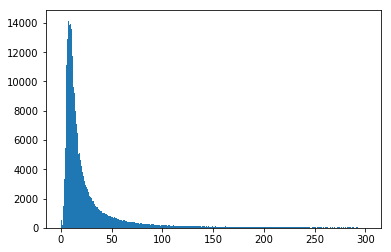

In [26]:
# Histogram for column 'amount_paid_sum'
plt.hist(orders_per_client[orders_per_client['amount_paid_sum'] < 300]['amount_paid_sum'], bins=300)
plt.show()

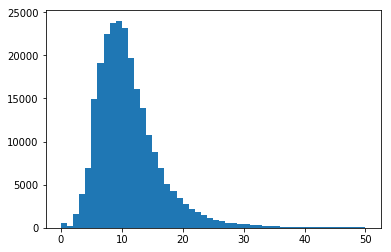

In [27]:
# Histogram for column 'amount_paid_quantile75'
plt.hist(orders_per_client[orders_per_client['amount_paid_quantile75'] < 50]['amount_paid_quantile75'], bins=50)
plt.show()

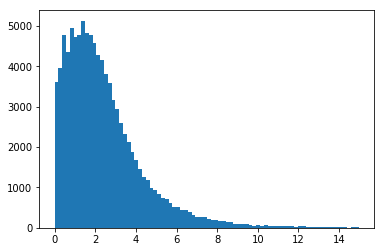

In [28]:
# Histogram for column 'amount_paid_std'
plt.hist(orders_per_client[(orders_per_client['amount_paid_std'] < 15) &\
                           (orders_per_client['amount_paid_std'] > 0)]['amount_paid_std'], bins=80)
plt.show()

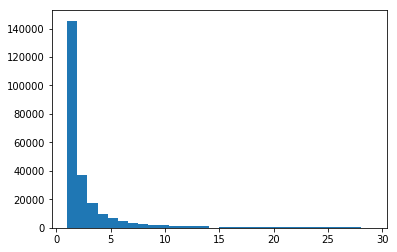

In [29]:
# Histogram for column 'orders_num'
plt.hist(orders_per_client[orders_per_client['orders_num'] < 30]['orders_num'], bins=30)
plt.show()

Column : orders_num, Mean : 3.205, Median : 1.000, Std : 7.026


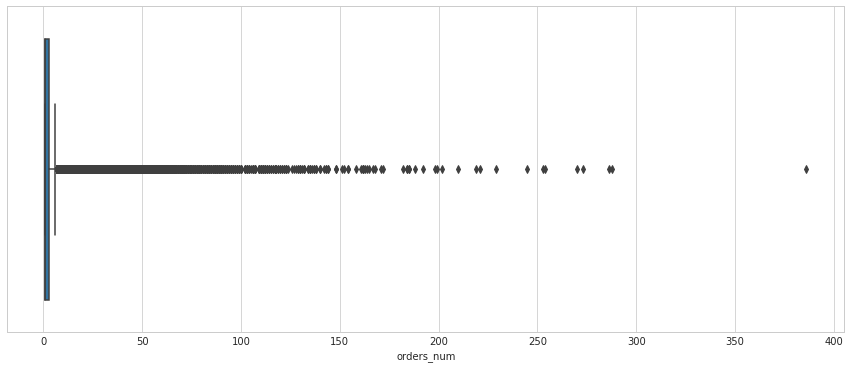

Column : is_failed_num, Mean : 0.101, Median : 0.000, Std : 0.656


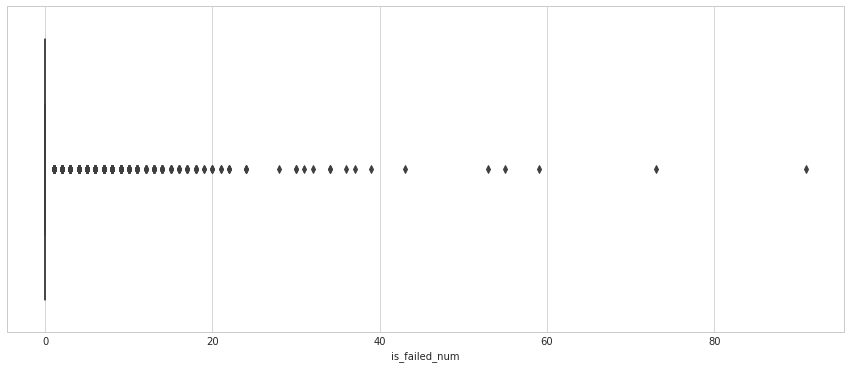

Column : voucher_amount_sum, Mean : 0.293, Median : 0.000, Std : 1.826


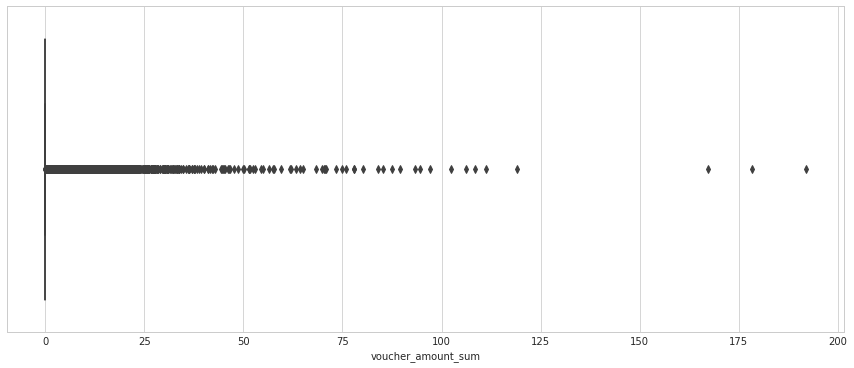

Column : delivery_fee_mean, Mean : 0.188, Median : 0.000, Std : 0.352


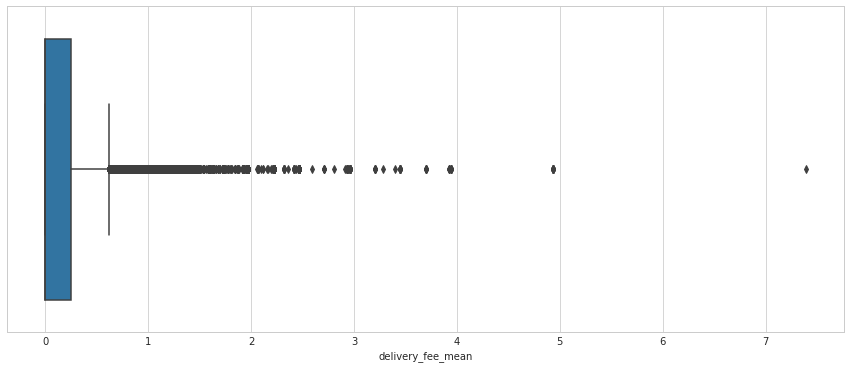

Column : delivery_fee_sum, Mean : 0.581, Median : 0.000, Std : 2.333


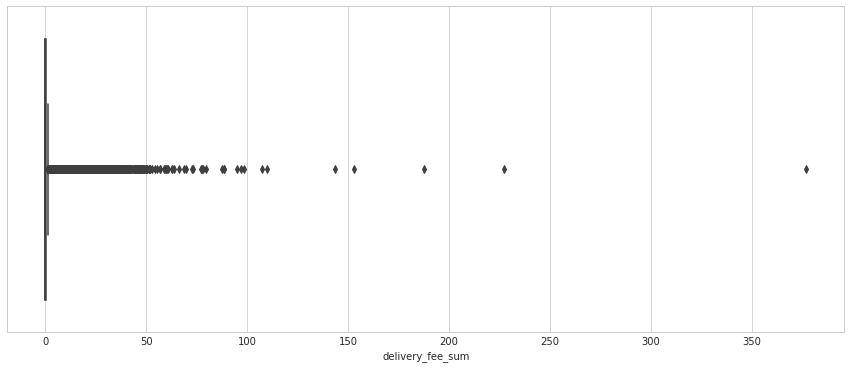

Column : delivery_fee_num, Mean : 0.770, Median : 0.000, Std : 2.821


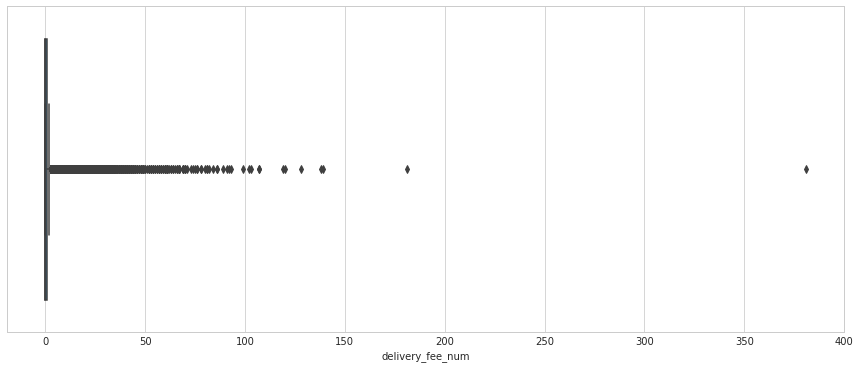

Column : restaurant_id_unq_num, Mean : 1.761, Median : 1.000, Std : 1.844


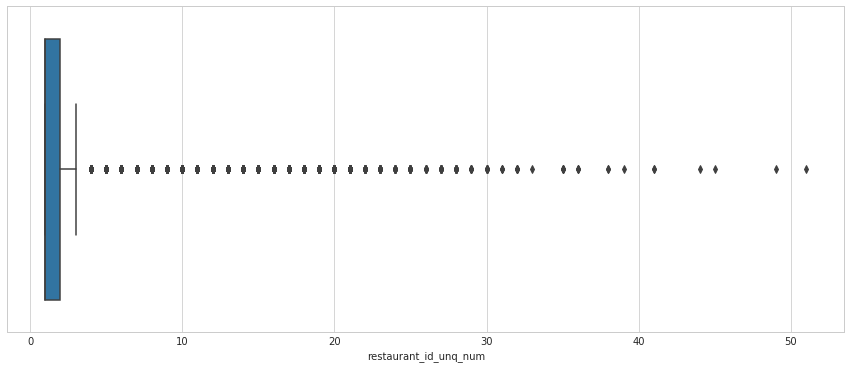

Column : city_id_unq_num, Mean : 1.045, Median : 1.000, Std : 0.263


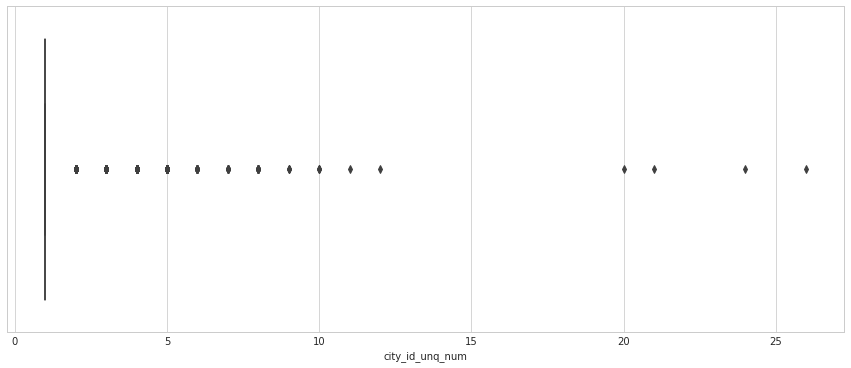

Column : payment_id_unq_num, Mean : 1.163, Median : 1.000, Std : 0.422


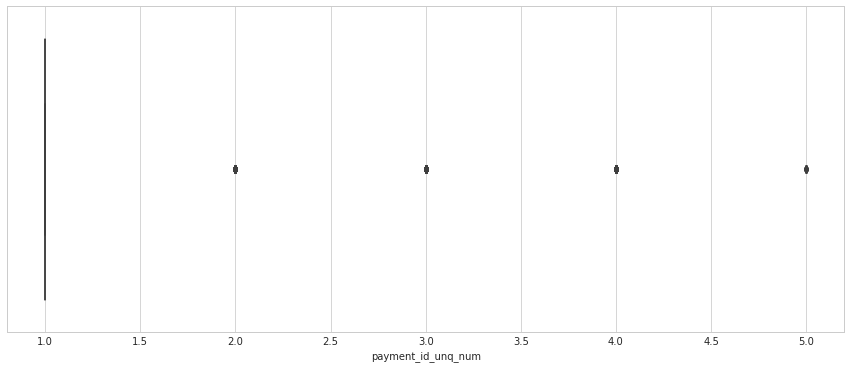

Column : platform_id_unq_num, Mean : 1.206, Median : 1.000, Std : 0.506


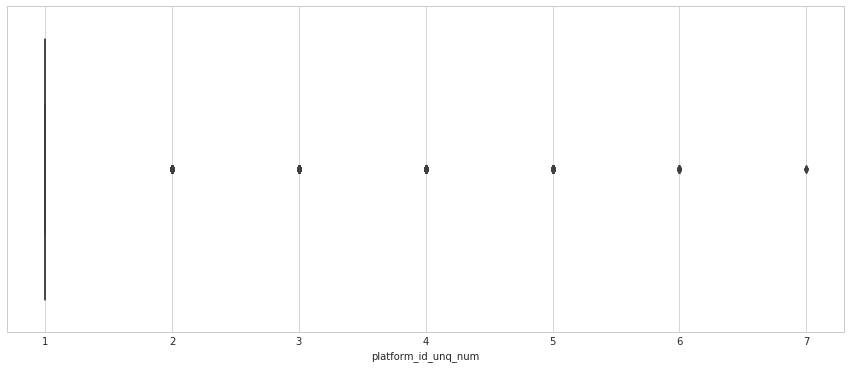

Column : transmission_id_unq_num, Mean : 1.366, Median : 1.000, Std : 0.710


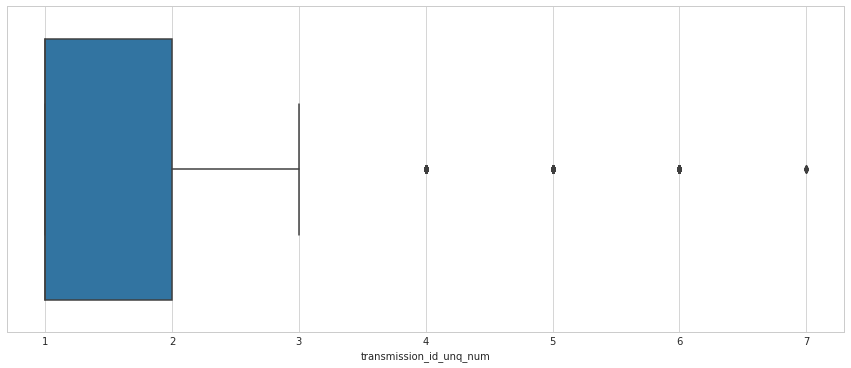

Column : amount_paid_mean, Mean : 10.807, Median : 9.717, Std : 5.799


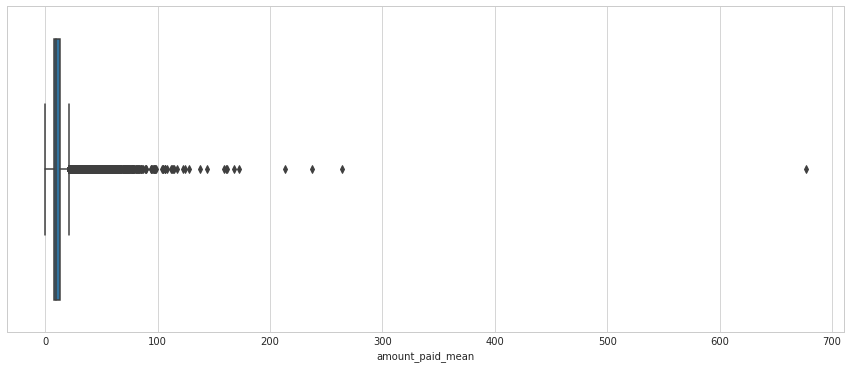

Column : amount_paid_sum, Mean : 32.634, Median : 14.178, Std : 70.026


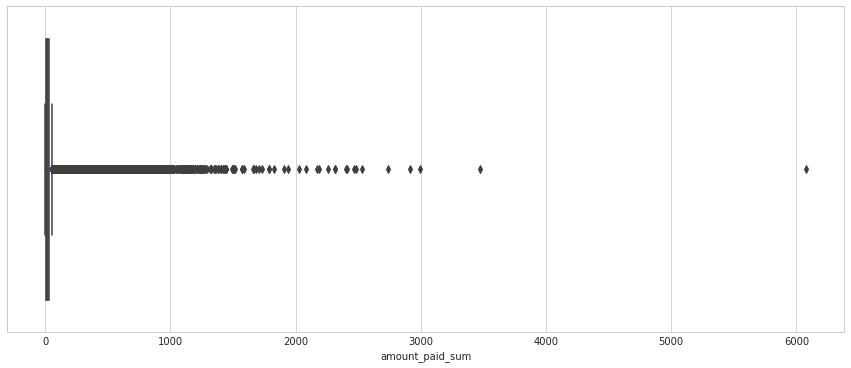

Column : amount_paid_std, Mean : 0.995, Median : 0.000, Std : 2.153


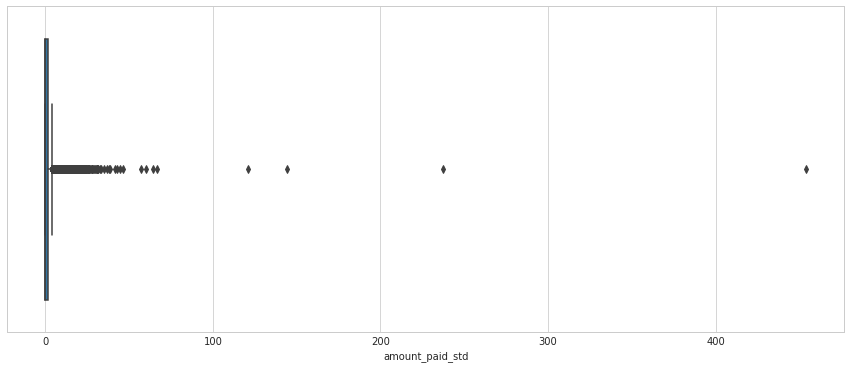

Column : amount_paid_quantile75, Mean : 11.298, Median : 10.222, Std : 6.196


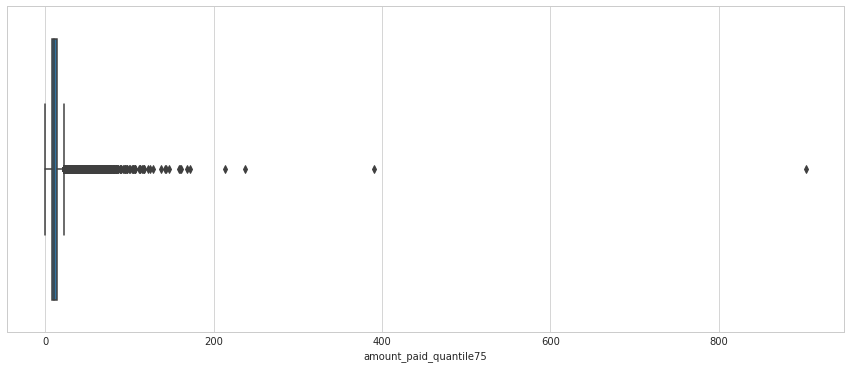

Column : payment_id_1491_num, Mean : 0.149, Median : 0.000, Std : 1.548


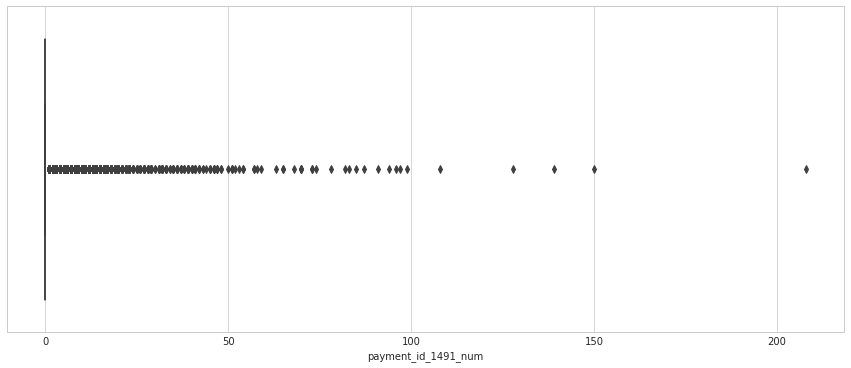

Column : payment_id_1523_num, Mean : 0.020, Median : 0.000, Std : 0.754


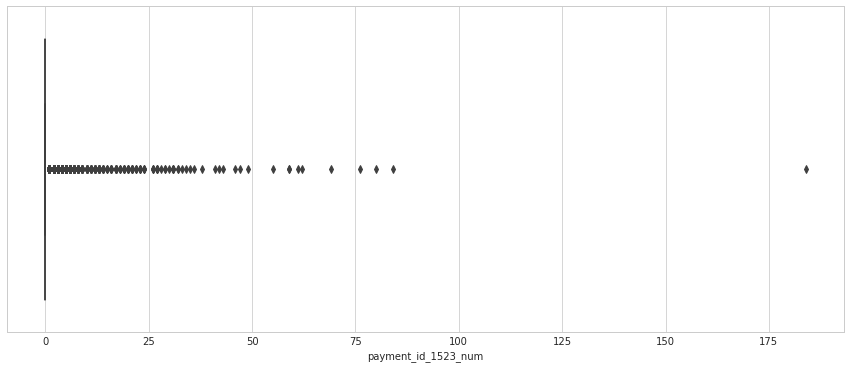

Column : payment_id_1619_num, Mean : 1.942, Median : 1.000, Std : 4.652


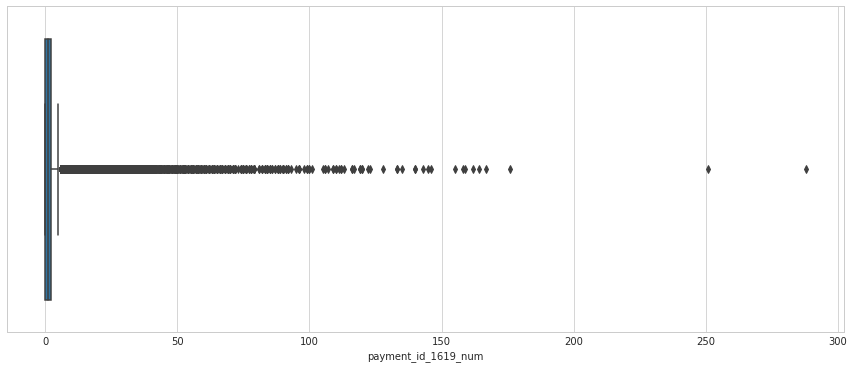

Column : payment_id_1779_num, Mean : 0.954, Median : 0.000, Std : 3.803


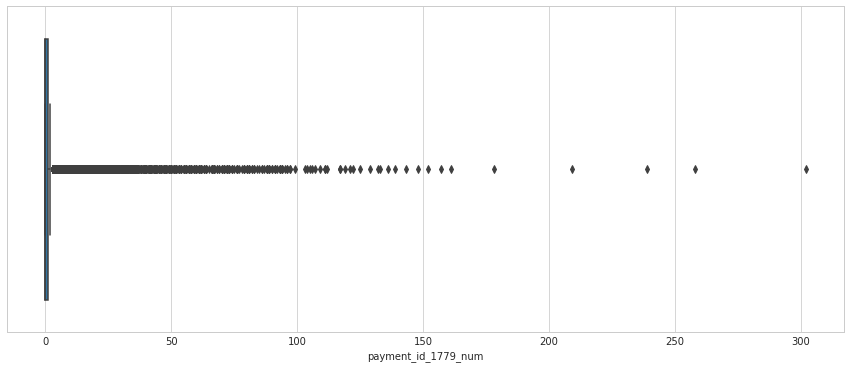

Column : payment_id_1811_num, Mean : 0.141, Median : 0.000, Std : 1.282


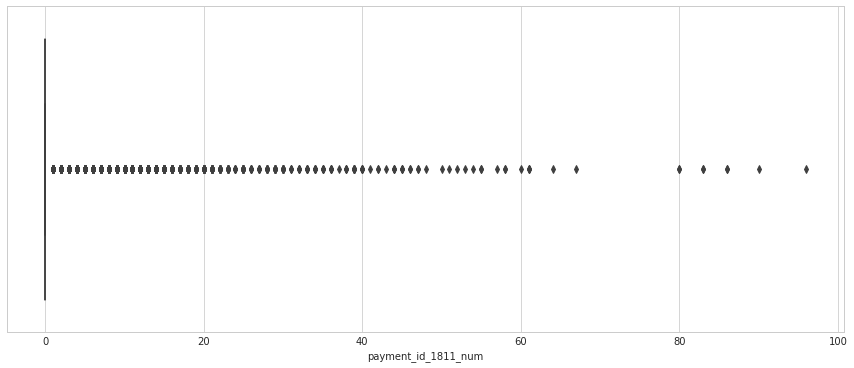

Column : platform_id_525_num, Mean : 0.004, Median : 0.000, Std : 0.073


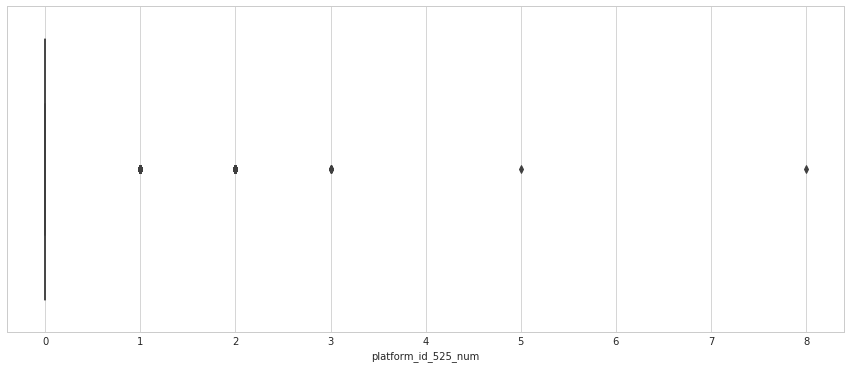

Column : platform_id_22167_num, Mean : 0.000, Median : 0.000, Std : 0.003


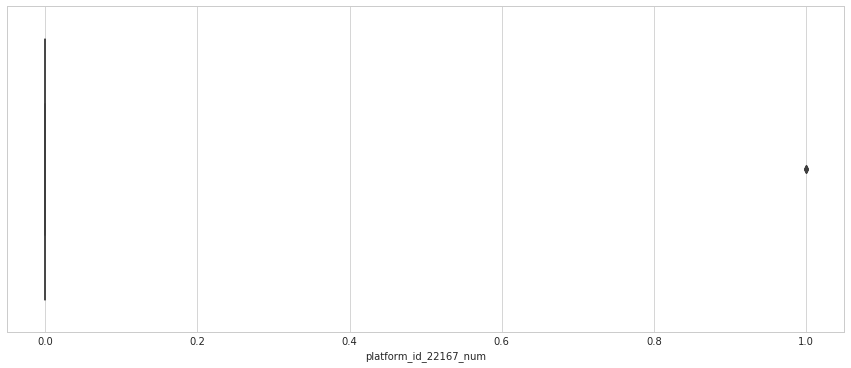

Column : platform_id_22263_num, Mean : 0.001, Median : 0.000, Std : 0.073


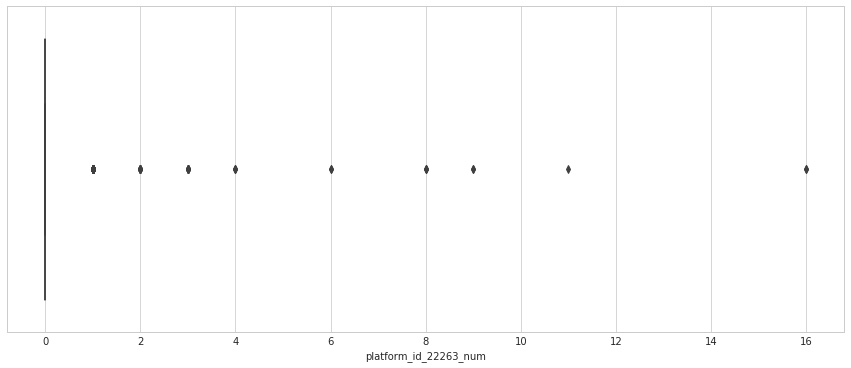

Column : platform_id_22295_num, Mean : 0.000, Median : 0.000, Std : 0.002


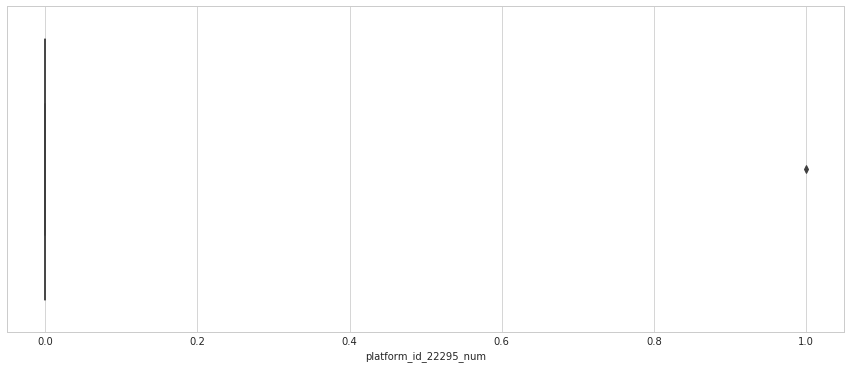

Column : platform_id_29463_num, Mean : 0.984, Median : 0.000, Std : 3.787


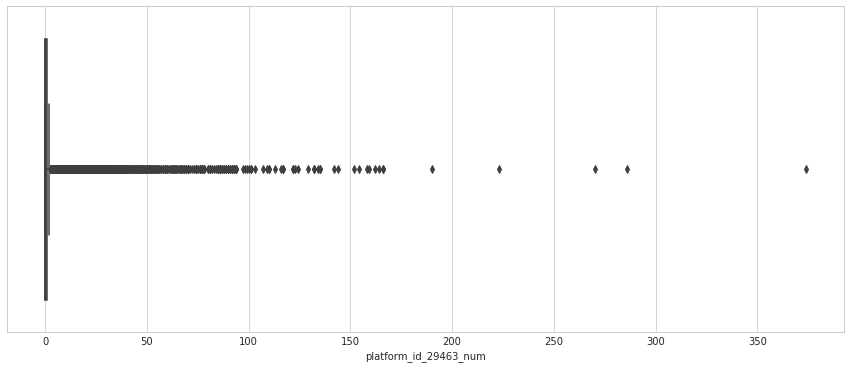

Column : platform_id_29495_num, Mean : 0.045, Median : 0.000, Std : 0.375


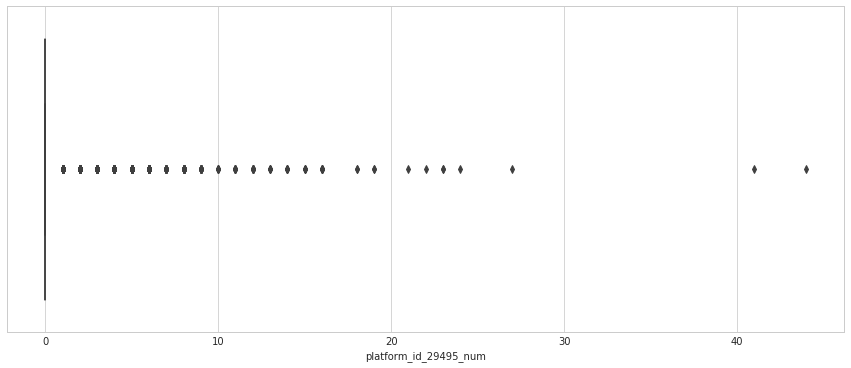

Column : platform_id_29751_num, Mean : 0.079, Median : 0.000, Std : 1.221


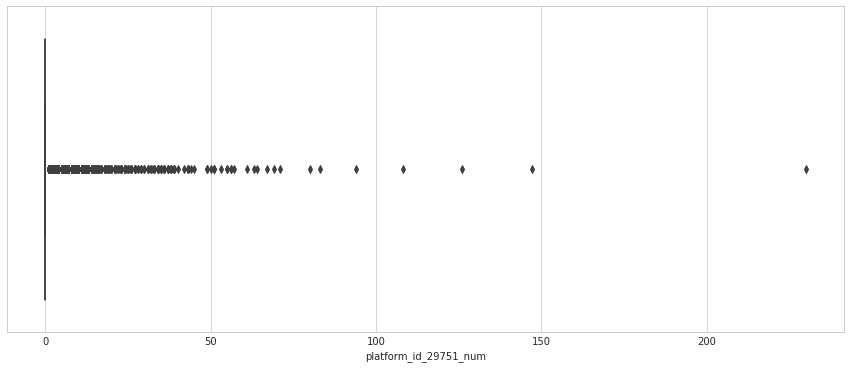

Column : platform_id_29815_num, Mean : 0.648, Median : 0.000, Std : 3.341


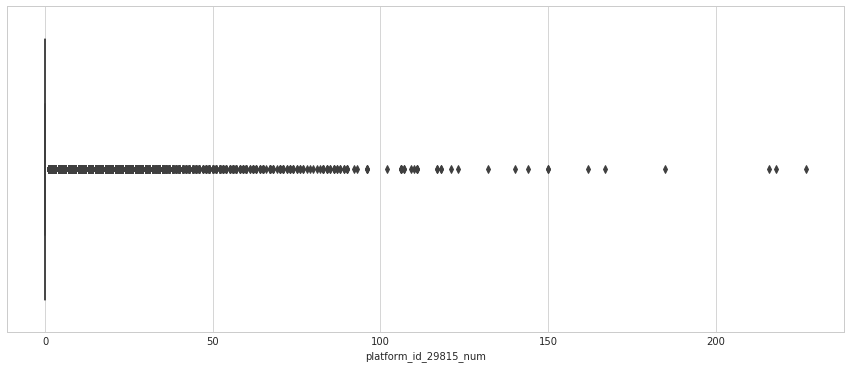

Column : platform_id_30135_num, Mean : 0.002, Median : 0.000, Std : 0.225


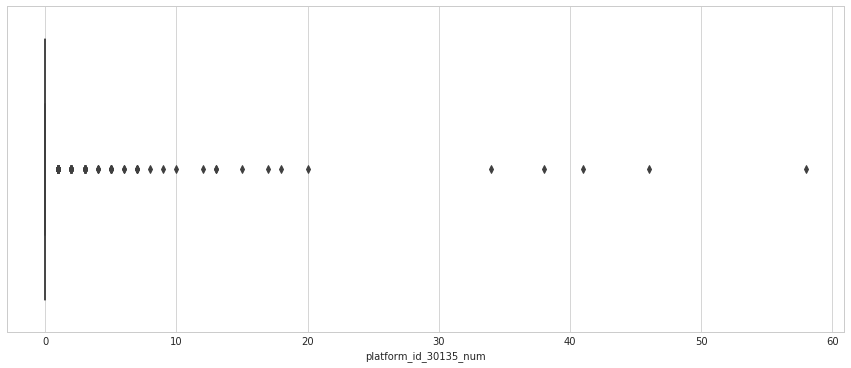

Column : platform_id_30199_num, Mean : 0.008, Median : 0.000, Std : 0.324


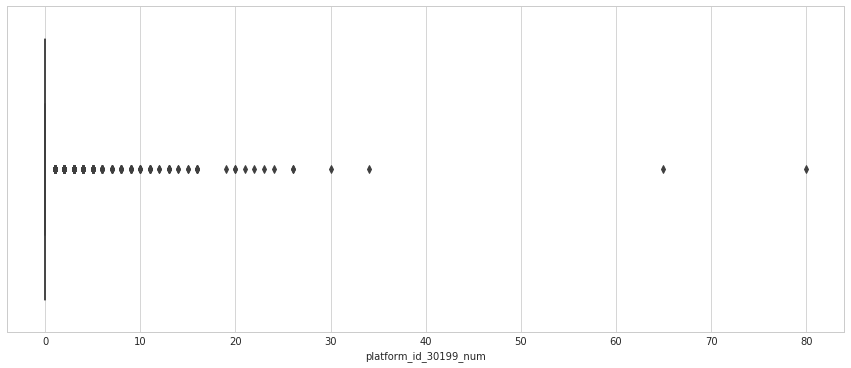

Column : platform_id_30231_num, Mean : 0.883, Median : 0.000, Std : 4.027


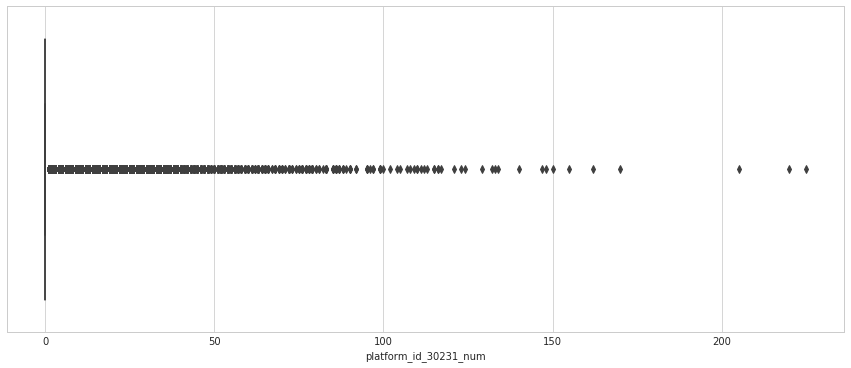

Column : platform_id_30359_num, Mean : 0.422, Median : 0.000, Std : 1.648


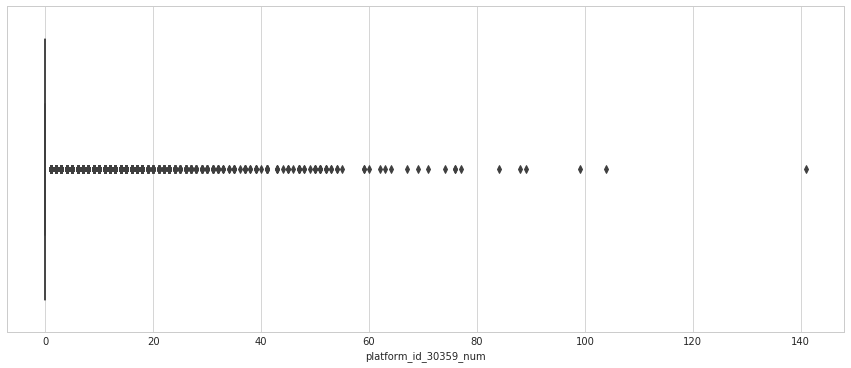

Column : platform_id_30391_num, Mean : 0.100, Median : 0.000, Std : 0.576


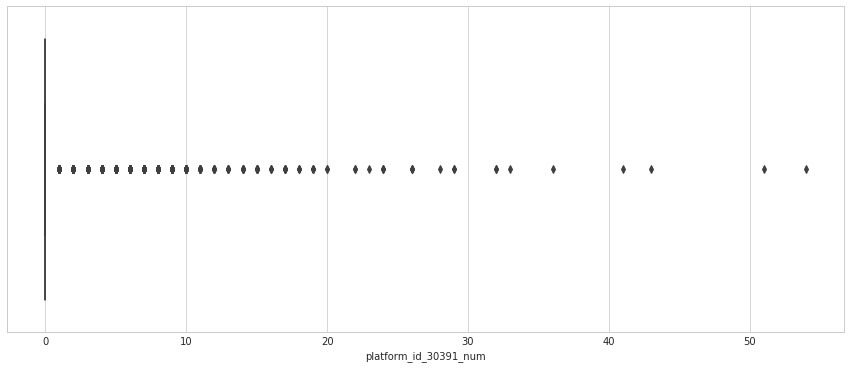

Column : platform_id_30423_num, Mean : 0.028, Median : 0.000, Std : 0.263


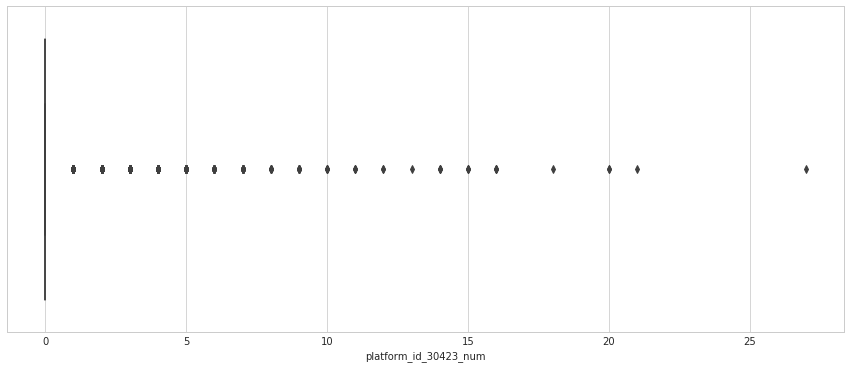

Column : transmission_id_212_num, Mean : 0.052, Median : 0.000, Std : 0.538


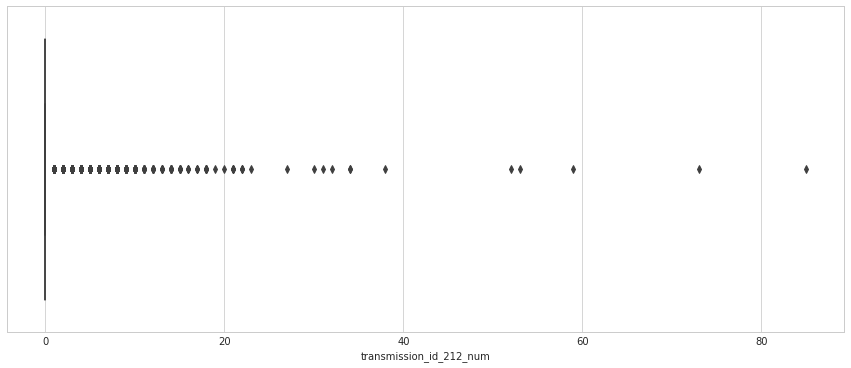

Column : transmission_id_1988_num, Mean : 0.001, Median : 0.000, Std : 0.033


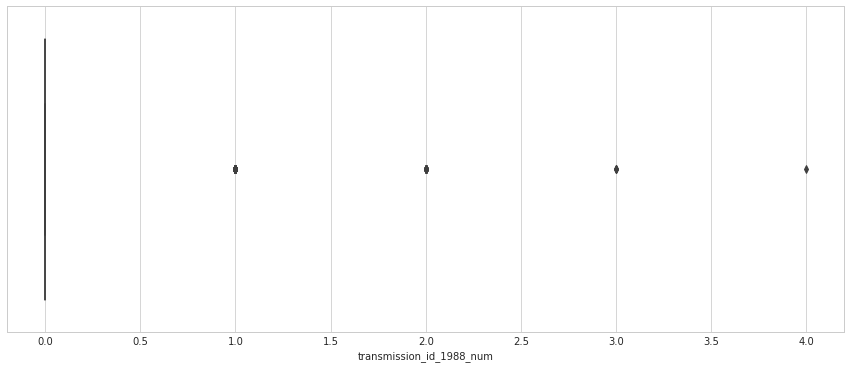

Column : transmission_id_2020_num, Mean : 0.000, Median : 0.000, Std : 0.002


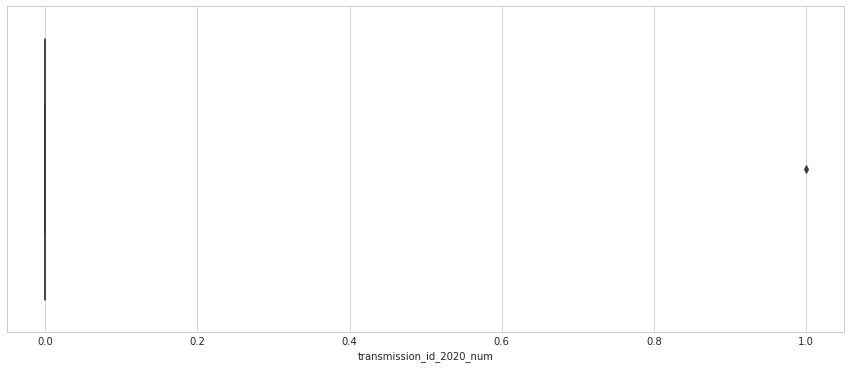

Column : transmission_id_4196_num, Mean : 0.021, Median : 0.000, Std : 0.321


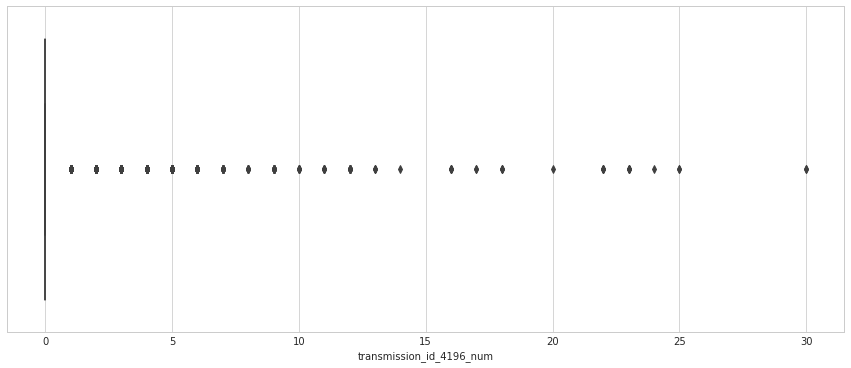

Column : transmission_id_4228_num, Mean : 0.821, Median : 0.000, Std : 2.780


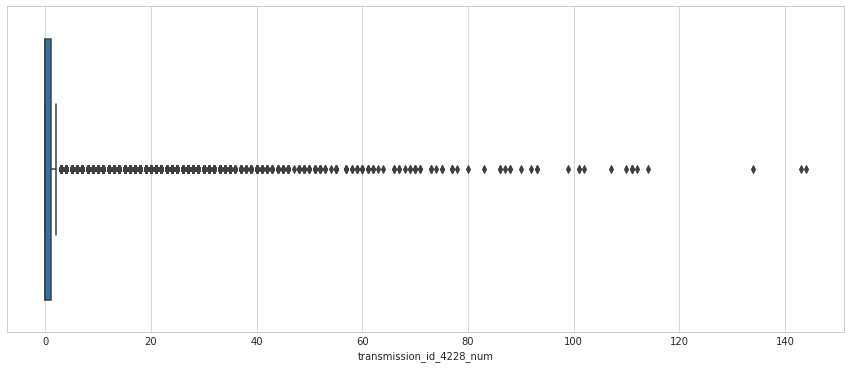

Column : transmission_id_4260_num, Mean : 0.059, Median : 0.000, Std : 0.518


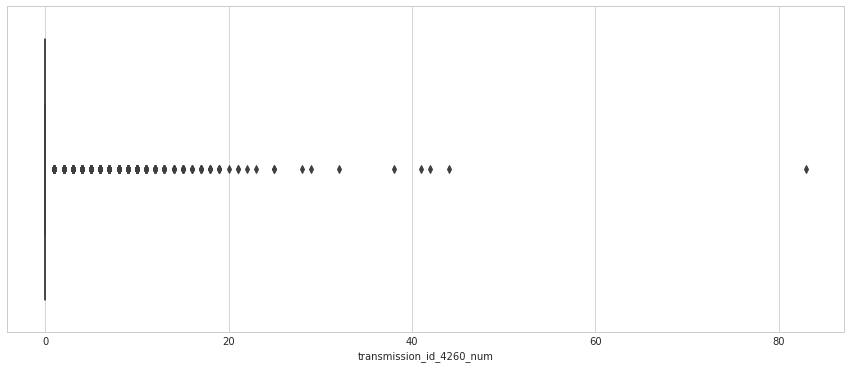

Column : transmission_id_4324_num, Mean : 0.830, Median : 0.000, Std : 2.507


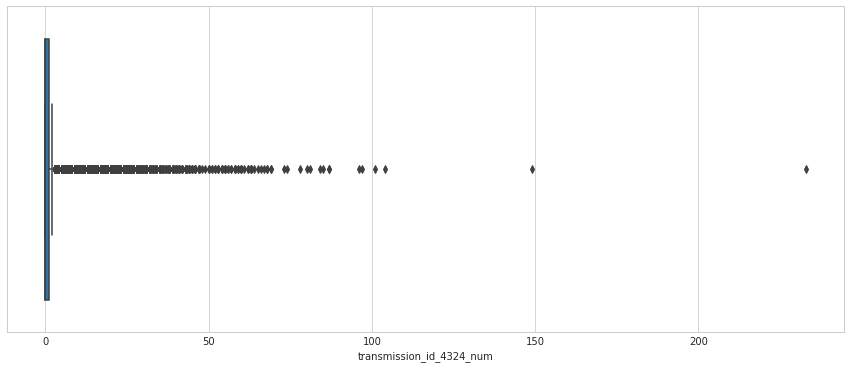

Column : transmission_id_4356_num, Mean : 1.392, Median : 1.000, Std : 3.922


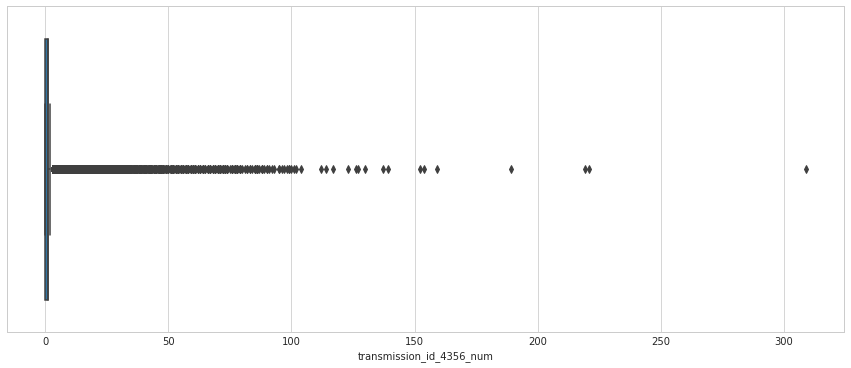

Column : transmission_id_4996_num, Mean : 0.027, Median : 0.000, Std : 0.265


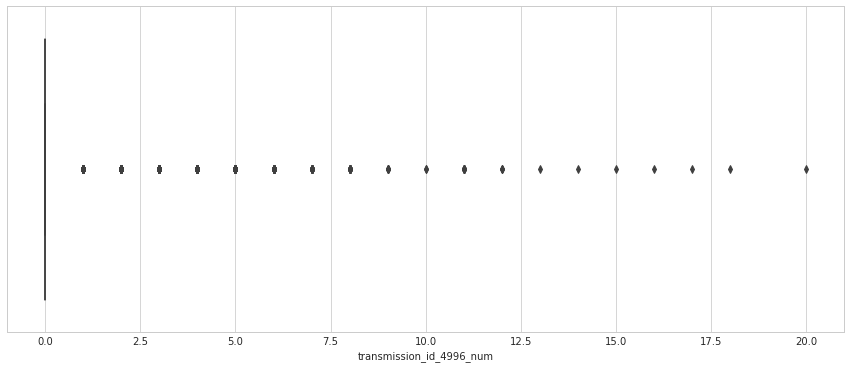

Column : transmission_id_21124_num, Mean : 0.001, Median : 0.000, Std : 0.028


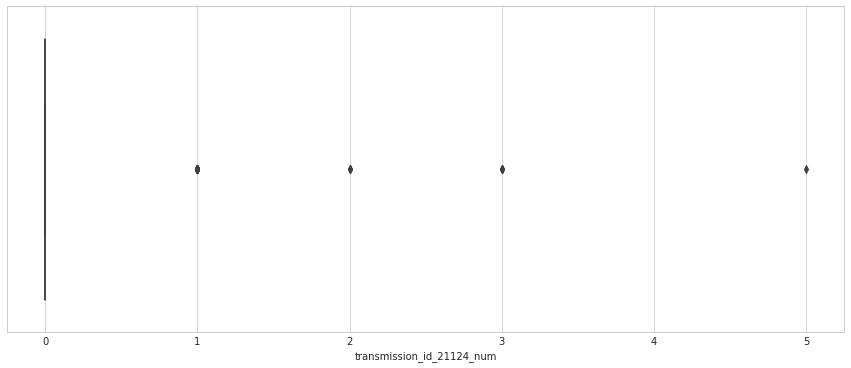

In [30]:
# Check outliers
sns.set_style("whitegrid")
for col in orders_per_client.columns.tolist()[1:]:
    print('Column : {}, Mean : {:.3f}, Median : {:.3f}, Std : {:.3f}'.format(col, 
                                                               orders_per_client[col].mean(), 
                                                               orders_per_client[col].median(),
                                                               orders_per_client[col].std()))
    plt.figure(figsize=(15,6))
    sns.boxplot(x=orders_per_client[col])
    plt.show()

## Correlations of columns

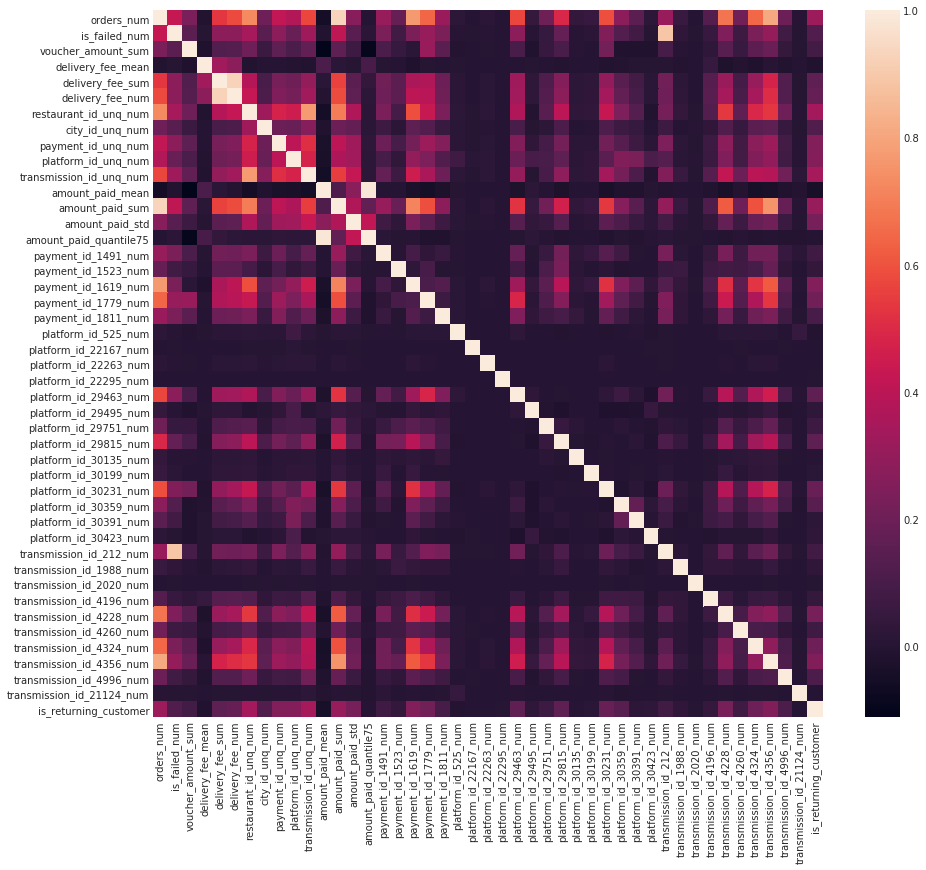

In [31]:
# Visualize correlation matrix
corr = orders_per_client.merge(labeled_data, on='customer_id', how='left', validate='one_to_one').corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [32]:
# Create correlation matrix
corr_matrix = orders_per_client.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

# Drop highly correlated columns
orders_per_client.drop(to_drop, axis=1, inplace=True)

['delivery_fee_num', 'amount_paid_sum', 'amount_paid_quantile75']


## Create training data

In [33]:
data_train = orders_per_client.merge(labeled_data, on='customer_id', how='left', validate='one_to_one')

In [34]:
data_train.shape

(245455, 43)

In [35]:
data_train.head(3)

,customer_id,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_std,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num,is_returning_customer
0,000097eabfd9,1,0,0.0,0.000,0.000,1,1,1,1,1,11.46960,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000e2c6d9be,1,0,0.0,0.000,0.000,1,1,1,1,1,9.55800,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,000133bb597f,1,0,0.0,0.493,0.493,1,1,1,1,1,5.93658,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [36]:
# Check NAs
data_train.isna().sum(axis=0)

customer_id                  0
orders_num                   0
is_failed_num                0
voucher_amount_sum           0
delivery_fee_mean            0
delivery_fee_sum             0
restaurant_id_unq_num        0
city_id_unq_num              0
payment_id_unq_num           0
platform_id_unq_num          0
transmission_id_unq_num      0
amount_paid_mean             0
amount_paid_std              0
payment_id_1491_num          0
payment_id_1523_num          0
payment_id_1619_num          0
payment_id_1779_num          0
payment_id_1811_num          0
platform_id_525_num          0
platform_id_22167_num        0
platform_id_22263_num        0
platform_id_22295_num        0
platform_id_29463_num        0
platform_id_29495_num        0
platform_id_29751_num        0
platform_id_29815_num        0
platform_id_30135_num        0
platform_id_30199_num        0
platform_id_30231_num        0
platform_id_30359_num        0
platform_id_30391_num        0
platform_id_30423_num        0
transmis

In [37]:
# Rate of positive/neg labels 
data_train['is_returning_customer'].value_counts() / data_train.shape[0]

0    0.773861
1    0.226139
Name: is_returning_customer, dtype: float64

In [38]:
# Create X, y matrices
X = data_train.iloc[:, 1:-1]
y = data_train.iloc[:, -1]

In [39]:
# Normalize X matrix
scaler = preprocessing.StandardScaler().fit(X)
scaler_file = 'scaler.pkl'
pickle.dump(scaler, open(scaler_file, 'wb'))
X_norm = pd.DataFrame(scaler.transform(X), columns=X.columns)
# df[columns_norm] = df[columns_norm].astype('float32')

In [40]:
# Save the training table (label is the last column)
Xy_norm = pd.concat([X_norm, y], axis=1)
Xy_norm.to_feather('Xy_norm.feather')

In [41]:
Xy_norm.shape

(245455, 42)

In [42]:
Xy_norm.head(3)

,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_std,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num,is_returning_customer
0,-0.313796,-0.153931,-0.160605,-0.534689,-0.248892,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,0.114188,-0.462233,-0.096045,-0.026364,-0.417414,0.012129,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,0.029065,-0.256269,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,-0.330953,-0.100007,-0.103457,-0.021054,0
1,-0.313796,-0.153931,-0.160605,-0.534689,-0.248892,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,-0.215465,-0.462233,-0.096045,-0.026364,-0.202441,-0.250828,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,-0.219259,0.350588,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,-0.330953,-0.100007,-0.103457,-0.021054,0
2,-0.313796,-0.153931,-0.160605,0.864187,-0.037560,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,-0.839974,-0.462233,-0.096045,-0.026364,-0.202441,-0.250828,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,-0.219259,0.350588,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,0.067902,-0.354967,-0.103457,-0.021054,1


## Data table for sequence model (no aggregation)

In [51]:
order_data = pd.read_csv('machine_learning_challenge_order_data.csv')
labeled_data = pd.read_csv('machine_learning_challenge_labeled_data.csv')

In [52]:
# Create dummies for categorical columns with reasonable number of values
payment_id_dummies = pd.get_dummies(order_data['payment_id'], prefix='payment_id')
platform_id_dummies = pd.get_dummies(order_data['platform_id'], prefix='platform_id')
transmission_id_dummies = pd.get_dummies(order_data['transmission_id'], prefix='transmission_id')
dummies = [payment_id_dummies, platform_id_dummies, transmission_id_dummies]
# order_data.drop(['payment_id', 'platform_id', 'transmission_id'], axis=1, inplace=True)
order_data = pd.concat([order_data]+dummies, axis=1)

In [53]:
order_data.head(3)

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [54]:
# Drop useless columns
order_data.drop(['order_date', 'customer_order_rank', 'restaurant_id', 'restaurant_id', 
                 'city_id', 'payment_id', 'platform_id', 'transmission_id'], 
                axis=1, inplace=True)

In [55]:
# Add label column to each order
order_data_lbl = order_data.merge(labeled_data, on='customer_id', how='left', validate='many_to_one')

In [56]:
order_data_lbl.shape

(786600, 36)

In [57]:
order_data_lbl.head(3)

,customer_id,order_hour,is_failed,voucher_amount,delivery_fee,amount_paid,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124,is_returning_customer
0,000097eabfd9,19,0,0.0,0.000,11.46960,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000e2c6d9be,20,0,0.0,0.000,9.55800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,000133bb597f,19,0,0.0,0.493,5.93658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [58]:
# Save table
order_data_lbl.to_feather('order_data_lbl.feather')